In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Get Dataset

In [2]:
import os
path = os.getcwd()

In [3]:
video_dataset_dir = os.path.dirname('C:\\Users\\Ta Quang Ngoc\\Desktop\\sign\\')
words = os.listdir(video_dataset_dir)
print(words)
list_videos_dir = []
for word in words:
    list_videos_dir.append(os.path.join(video_dataset_dir, word))

['an_mung', 'an_ui', 'ap_dung', 'ban_khoan', 'benh_nhan', 'be_mac', 'biet', 'bieu_tang']


# Detect and convert video to numpy array

In [4]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils

In [48]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                 
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):

    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

def extract_keypoints(results):
    key1 = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    key2 = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    print("key1: ", key1.shape)
    print("key2: ", key2.shape)
    print("lh: ", lh.shape)
    print("rh: ", rh.shape)
    return np.concatenate([key1, key2, lh, rh])

In [6]:
DATA_PATH = os.path.join('data_npy_lite')
sequence_length = 30

In [ ]:
for word in words:
    videos_dir = os.path.join(video_dataset_dir, word)
    for video in os.listdir(videos_dir):
        video_path = os.path.join(videos_dir, video)
        cap = cv2.VideoCapture(video_path)
        video = video.replace('.mp4', '')
        os.makedirs(os.path.join(DATA_PATH, word, video))
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

            for frame_num in range(1, sequence_length + 1):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, word, video, str(frame_num))
                print(npy_path)
                np.save(npy_path, keypoints)

In [ ]:
# from moviepy.editor import *
# for word in words:
#     videos_dir = os.path.join(video_dataset_dir, word)
#     for video in os.listdir(videos_dir):
#         video_path = os.path.join(videos_dir, video)
#         video = cv2.VideoCapture(video_path)
#         fps = video.get(cv2.CAP_PROP_FPS)
#         print (f"{video_path} ", fps)



# Preprocess Data and Create Labels

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
actions = ['an_mung', 'an_ui', 'ap_dung', 'ban_khoan', 'benh_nhan', 'be_mac', 'biet', 'bieu_tang']
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'an_mung': 0,
 'an_ui': 1,
 'ap_dung': 2,
 'ban_khoan': 3,
 'benh_nhan': 4,
 'be_mac': 5,
 'biet': 6,
 'bieu_tang': 7}

In [9]:
sequences, labels = [], []
for word in words:
    videos_dir = os.path.join(video_dataset_dir, word)
    for video in os.listdir(videos_dir):
        video = video.replace('.mp4', '')
        window = []
        for frame_num in range(1, sequence_length+1):
            res = np.load(os.path.join(DATA_PATH, word, video, "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[actions[words.index(word)]])
    print(word, " ok")

an_mung  ok
an_ui  ok
ap_dung  ok
ban_khoan  ok
benh_nhan  ok
be_mac  ok
biet  ok
bieu_tang  ok


In [10]:
X = np.array(sequences)
X.shape

(240, 30, 1662)

In [16]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
print(y_train.shape,
y_test.shape,
X_train.shape)

(192, 8) (48, 8) (192, 30, 1662)


# Build Model LSTM 

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [19]:
log_dir = os.path.join('allLogs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='sigmoid', input_shape=(30,1662)))


model.add(LSTM(128, return_sequences=True, activation='sigmoid'))


model.add(LSTM(64, return_sequences=False, activation='sigmoid'))


model.add(Dense(64, activation='sigmoid'))


model.add(Dense(32, activation='sigmoid'))


model.add(Dense(np.array(actions).shape[0], activation='softmax'))

In [24]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(30,1662)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(8, activation='softmax'))    
model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['categorical_accuracy'])

In [ ]:
model.compile(optimizer= 'Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
history = model.fit(X_train, y_train, epochs=600, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/600
6/6 [==============================] - 8s 575ms/step - loss: 2.0735 - categorical_accuracy: 0.1490 - val_loss: 2.0527 - val_categorical_accuracy: 0.0833
Epoch 2/600
6/6 [==============================] - 0s 84ms/step - loss: 2.0237 - categorical_accuracy: 0.2094 - val_loss: 1.9681 - val_categorical_accuracy: 0.2083
Epoch 3/600
6/6 [==============================] - 0s 80ms/step - loss: 1.8985 - categorical_accuracy: 0.2763 - val_loss: 1.8869 - val_categorical_accuracy: 0.1875
Epoch 4/600
6/6 [==============================] - 0s 74ms/step - loss: 1.8141 - categorical_accuracy: 0.2484 - val_loss: 1.8095 - val_categorical_accuracy: 0.1875
Epoch 5/600
6/6 [==============================] - 0s 77ms/step - loss: 1.6955 - categorical_accuracy: 0.3042 - val_loss: 1.6988 - val_categorical_accuracy: 0.2708
Epoch 6/600
6/6 [==============================] - 1s 74ms/step - loss: 1.6273 - categorical_accuracy: 0.3133 - val_loss: 1.6834 - val_categorical_accuracy: 0.4167
Epoch 7/600
6/6

Epoch 51/600
6/6 [==============================] - 0s 71ms/step - loss: 0.5505 - categorical_accuracy: 0.8269 - val_loss: 0.7086 - val_categorical_accuracy: 0.7292
Epoch 52/600
6/6 [==============================] - 1s 76ms/step - loss: 0.6786 - categorical_accuracy: 0.7284 - val_loss: 0.9209 - val_categorical_accuracy: 0.6250
Epoch 53/600
6/6 [==============================] - 0s 73ms/step - loss: 0.6425 - categorical_accuracy: 0.7254 - val_loss: 1.0504 - val_categorical_accuracy: 0.6250
Epoch 54/600
6/6 [==============================] - 1s 82ms/step - loss: 0.7043 - categorical_accuracy: 0.7635 - val_loss: 0.7662 - val_categorical_accuracy: 0.7292
Epoch 55/600
6/6 [==============================] - 1s 94ms/step - loss: 0.4964 - categorical_accuracy: 0.8366 - val_loss: 0.6055 - val_categorical_accuracy: 0.7917
Epoch 56/600
6/6 [==============================] - 1s 122ms/step - loss: 0.4579 - categorical_accuracy: 0.8659 - val_loss: 0.5668 - val_categorical_accuracy: 0.7708
Epoch 57/

6/6 [==============================] - 1s 77ms/step - loss: 0.2717 - categorical_accuracy: 0.9220 - val_loss: 0.4009 - val_categorical_accuracy: 0.8750
Epoch 101/600
6/6 [==============================] - 0s 67ms/step - loss: 0.2707 - categorical_accuracy: 0.9129 - val_loss: 0.4088 - val_categorical_accuracy: 0.9167
Epoch 102/600
6/6 [==============================] - 0s 72ms/step - loss: 0.2517 - categorical_accuracy: 0.9342 - val_loss: 0.3432 - val_categorical_accuracy: 0.8542
Epoch 103/600
6/6 [==============================] - 0s 71ms/step - loss: 0.1782 - categorical_accuracy: 0.9327 - val_loss: 0.3334 - val_categorical_accuracy: 0.8542
Epoch 104/600
6/6 [==============================] - 0s 70ms/step - loss: 0.1791 - categorical_accuracy: 0.9424 - val_loss: 0.3830 - val_categorical_accuracy: 0.8333
Epoch 105/600
6/6 [==============================] - 0s 78ms/step - loss: 0.2623 - categorical_accuracy: 0.9182 - val_loss: 0.6775 - val_categorical_accuracy: 0.7500
Epoch 106/600
6/6 

6/6 [==============================] - 0s 70ms/step - loss: 0.0652 - categorical_accuracy: 0.9950 - val_loss: 0.4528 - val_categorical_accuracy: 0.8542
Epoch 150/600
6/6 [==============================] - 0s 70ms/step - loss: 0.0554 - categorical_accuracy: 0.9848 - val_loss: 0.4631 - val_categorical_accuracy: 0.8542
Epoch 151/600
6/6 [==============================] - 0s 76ms/step - loss: 0.0386 - categorical_accuracy: 1.0000 - val_loss: 0.3760 - val_categorical_accuracy: 0.8750
Epoch 152/600
6/6 [==============================] - 0s 70ms/step - loss: 0.0301 - categorical_accuracy: 1.0000 - val_loss: 0.3162 - val_categorical_accuracy: 0.8750
Epoch 153/600
6/6 [==============================] - 0s 70ms/step - loss: 0.0306 - categorical_accuracy: 1.0000 - val_loss: 0.3246 - val_categorical_accuracy: 0.8958
Epoch 154/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0263 - categorical_accuracy: 1.0000 - val_loss: 0.3926 - val_categorical_accuracy: 0.8958
Epoch 155/600
6/6 

Epoch 198/600
6/6 [==============================] - 1s 82ms/step - loss: 0.2514 - categorical_accuracy: 0.9414 - val_loss: 0.3761 - val_categorical_accuracy: 0.8125
Epoch 199/600
6/6 [==============================] - 0s 70ms/step - loss: 0.2290 - categorical_accuracy: 0.9231 - val_loss: 0.4919 - val_categorical_accuracy: 0.8333
Epoch 200/600
6/6 [==============================] - 0s 70ms/step - loss: 0.1742 - categorical_accuracy: 0.9393 - val_loss: 0.3011 - val_categorical_accuracy: 0.9167
Epoch 201/600
6/6 [==============================] - 0s 70ms/step - loss: 0.1235 - categorical_accuracy: 0.9769 - val_loss: 0.4034 - val_categorical_accuracy: 0.8958
Epoch 202/600
6/6 [==============================] - 0s 70ms/step - loss: 0.0939 - categorical_accuracy: 0.9869 - val_loss: 0.4039 - val_categorical_accuracy: 0.8750
Epoch 203/600
6/6 [==============================] - 0s 75ms/step - loss: 0.0947 - categorical_accuracy: 0.9803 - val_loss: 0.3610 - val_categorical_accuracy: 0.8958
Epoc

6/6 [==============================] - 1s 84ms/step - loss: 0.0385 - categorical_accuracy: 0.9883 - val_loss: 0.4717 - val_categorical_accuracy: 0.8750
Epoch 248/600
6/6 [==============================] - 1s 79ms/step - loss: 0.0291 - categorical_accuracy: 1.0000 - val_loss: 0.4168 - val_categorical_accuracy: 0.8750
Epoch 249/600
6/6 [==============================] - 0s 78ms/step - loss: 0.0232 - categorical_accuracy: 1.0000 - val_loss: 0.4240 - val_categorical_accuracy: 0.8750
Epoch 250/600
6/6 [==============================] - 1s 83ms/step - loss: 0.0205 - categorical_accuracy: 1.0000 - val_loss: 0.4095 - val_categorical_accuracy: 0.8958
Epoch 251/600
6/6 [==============================] - 0s 75ms/step - loss: 0.0206 - categorical_accuracy: 1.0000 - val_loss: 0.3907 - val_categorical_accuracy: 0.8958
Epoch 252/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0157 - categorical_accuracy: 1.0000 - val_loss: 0.4018 - val_categorical_accuracy: 0.8958
Epoch 253/600
6/6 

6/6 [==============================] - 0s 76ms/step - loss: 0.0060 - categorical_accuracy: 1.0000 - val_loss: 0.4578 - val_categorical_accuracy: 0.8958
Epoch 297/600
6/6 [==============================] - 1s 96ms/step - loss: 0.0066 - categorical_accuracy: 1.0000 - val_loss: 0.4564 - val_categorical_accuracy: 0.8958
Epoch 298/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0062 - categorical_accuracy: 1.0000 - val_loss: 0.4624 - val_categorical_accuracy: 0.8958
Epoch 299/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0062 - categorical_accuracy: 1.0000 - val_loss: 0.4618 - val_categorical_accuracy: 0.8958
Epoch 300/600
6/6 [==============================] - 0s 76ms/step - loss: 0.0061 - categorical_accuracy: 1.0000 - val_loss: 0.4572 - val_categorical_accuracy: 0.8958
Epoch 301/600
6/6 [==============================] - 1s 88ms/step - loss: 0.0055 - categorical_accuracy: 1.0000 - val_loss: 0.4580 - val_categorical_accuracy: 0.8958
Epoch 302/600
6/6 

6/6 [==============================] - 1s 81ms/step - loss: 0.0040 - categorical_accuracy: 1.0000 - val_loss: 0.4419 - val_categorical_accuracy: 0.8958
Epoch 346/600
6/6 [==============================] - 1s 81ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.4391 - val_categorical_accuracy: 0.8958
Epoch 347/600
6/6 [==============================] - 0s 83ms/step - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 0.4417 - val_categorical_accuracy: 0.8958
Epoch 348/600
6/6 [==============================] - 1s 83ms/step - loss: 0.0040 - categorical_accuracy: 1.0000 - val_loss: 0.4462 - val_categorical_accuracy: 0.8958
Epoch 349/600
6/6 [==============================] - 1s 89ms/step - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.4467 - val_categorical_accuracy: 0.8958
Epoch 350/600
6/6 [==============================] - 1s 81ms/step - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.4426 - val_categorical_accuracy: 0.8958
Epoch 351/600
6/6 

6/6 [==============================] - 1s 89ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.4396 - val_categorical_accuracy: 0.8958
Epoch 395/600
6/6 [==============================] - 0s 75ms/step - loss: 0.0030 - categorical_accuracy: 1.0000 - val_loss: 0.4366 - val_categorical_accuracy: 0.8958
Epoch 396/600
6/6 [==============================] - 0s 76ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.4413 - val_categorical_accuracy: 0.8958
Epoch 397/600
6/6 [==============================] - 0s 78ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.4443 - val_categorical_accuracy: 0.8958
Epoch 398/600
6/6 [==============================] - 0s 74ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.4395 - val_categorical_accuracy: 0.8958
Epoch 399/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0030 - categorical_accuracy: 1.0000 - val_loss: 0.4345 - val_categorical_accuracy: 0.8958
Epoch 400/600
6/6 

6/6 [==============================] - 1s 87ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.4318 - val_categorical_accuracy: 0.8958
Epoch 444/600
6/6 [==============================] - 1s 89ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.4444 - val_categorical_accuracy: 0.8958
Epoch 445/600
6/6 [==============================] - 1s 90ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - val_loss: 0.4404 - val_categorical_accuracy: 0.8958
Epoch 446/600
6/6 [==============================] - 1s 83ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - val_loss: 0.4366 - val_categorical_accuracy: 0.8958
Epoch 447/600
6/6 [==============================] - 1s 91ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.4388 - val_categorical_accuracy: 0.8958
Epoch 448/600
6/6 [==============================] - 1s 82ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.4350 - val_categorical_accuracy: 0.8958
Epoch 449/600
6/6 

6/6 [==============================] - 1s 79ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.4545 - val_categorical_accuracy: 0.8958
Epoch 493/600
6/6 [==============================] - 0s 74ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.4493 - val_categorical_accuracy: 0.8958
Epoch 494/600
6/6 [==============================] - 0s 72ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.4500 - val_categorical_accuracy: 0.8958
Epoch 495/600
6/6 [==============================] - 0s 72ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.4508 - val_categorical_accuracy: 0.8958
Epoch 496/600
6/6 [==============================] - 0s 74ms/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.4502 - val_categorical_accuracy: 0.8958
Epoch 497/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.4475 - val_categorical_accuracy: 0.8958
Epoch 498/600
6/6 

6/6 [==============================] - 1s 73ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.4622 - val_categorical_accuracy: 0.8958
Epoch 542/600
6/6 [==============================] - 0s 77ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.4660 - val_categorical_accuracy: 0.8958
Epoch 543/600
6/6 [==============================] - 0s 77ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.4577 - val_categorical_accuracy: 0.8958
Epoch 544/600
6/6 [==============================] - 0s 75ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.4643 - val_categorical_accuracy: 0.8958
Epoch 545/600
6/6 [==============================] - 0s 70ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.4681 - val_categorical_accuracy: 0.8958
Epoch 546/600
6/6 [==============================] - 0s 73ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.4651 - val_categorical_accuracy: 0.8958
Epoch 547/600
6/6 

6/6 [==============================] - 0s 77ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4776 - val_categorical_accuracy: 0.8958
Epoch 591/600
6/6 [==============================] - 1s 77ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4768 - val_categorical_accuracy: 0.8958
Epoch 592/600
6/6 [==============================] - 1s 80ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4763 - val_categorical_accuracy: 0.8958
Epoch 593/600
6/6 [==============================] - 1s 79ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4765 - val_categorical_accuracy: 0.8958
Epoch 594/600
6/6 [==============================] - 0s 78ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4783 - val_categorical_accuracy: 0.8958
Epoch 595/600
6/6 [==============================] - 1s 95ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4838 - val_categorical_accuracy: 0.8958
Epoch 596/600
6/6 

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 463,112
Trainable params: 463,112
Non-trainable params: 0
_________________________________________________________________


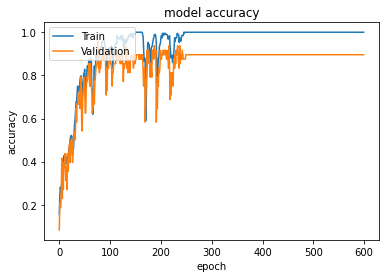

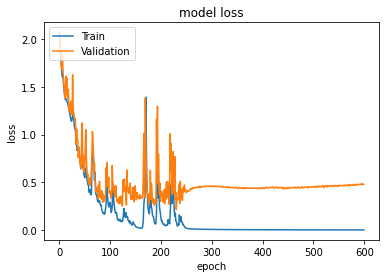

In [27]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predictions


In [31]:
res = model.predict(X_test)


In [29]:
index = np.argmax(res[1])
print(actions[index])

be_mac


In [32]:
from tensorflow import keras

In [33]:
model.save('finalvietlite.h5')

In [34]:
modelF= keras.models.load_model('finalvietlite.h5')

In [35]:
model.load_weights('finalvietlite.h5')

# Accuracy

In [36]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [37]:
yhtst = modelF.predict(X_test)
yhtrn = modelF.predict(X_train)

In [38]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhtst = np.argmax(yhtst, axis=1).tolist()

In [39]:
ytrain = np.argmax(y_train, axis=1).tolist()
yhtrn = np.argmax(yhtrn, axis=1).tolist()

In [40]:
multilabel_confusion_matrix(ytrue, yhtst)

array([[[44,  0],
        [ 1,  3]],

       [[42,  1],
        [ 0,  5]],

       [[39,  3],
        [ 0,  6]],

       [[44,  0],
        [ 0,  4]],

       [[40,  1],
        [ 0,  7]],

       [[42,  0],
        [ 0,  6]],

       [[39,  0],
        [ 3,  6]],

       [[41,  0],
        [ 1,  6]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhtst)

0.8958333333333334

In [42]:
accuracy_score(ytrain, yhtrn)

1.0

# Testing

In [43]:
colors = [(245,117,16), (117,245,16), (16,117,245),(16,17,245),(16,117,24),(17,25,160),(11,45,116),(170,205,165)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.rectangle(output_frame, (400, 400), (480, 480), (255,0,0), 2)
#         cv2.putText(output_frame, num, (400, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        
    return output_frame

In [49]:
# 1. New detection variables
sequence = []
threshold = 0.9

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        
#         print("SÁ: ", keypoints.shape)

        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = modelF.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Recognition Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh:  (63,)
rh:  (63,)
key1:  (132,)
key2:  (1404,)
lh